# K-mean Evaluation 
  
### The following sets of methods are used to evaluate an embedding  

The method used to evaluate the embedding is K-mean

### Import libraries

In [18]:
import networkx as nx
import numpy as np
import os
import re
import pydot

from eden.display import serialize_graph
from sklearn.decomposition import TruncatedSVD
from eden.graph import vectorize
from sklearn.cluster import KMeans


### Define methods

In [2]:
def import_data(folder_name,N):
    info={}
    files = os.listdir(folder_name)
    for f in files:
        m = re.search("([a-zA-Z]*_)(\w*)(.txt)", f)
        if(type(m)== re.Match):
            info[m.group(2)]=1

    #####(folder_name+"\\"+folder_name+"_"+f+".txt")



    path_A =folder_name+"\\"+folder_name+"_A.txt"
    path_graph_indicator =folder_name+"\\"+folder_name+"_graph_indicator.txt"



    AA = A_GI(path_A, path_graph_indicator,N) 


    ### create an array for the node attributes
    if(info.get("node_attributes")==1):
        path_node_attributes = folder_name+"\\"+folder_name+"_node_attributes.txt"
        file = open(path_node_attributes, "r") 
        nodes_attribute=[]
        for t in file:
            tmp=t.split(',')
            tmp = [float(x.strip()) for x in tmp]
            nodes_attribute.append(tmp)
        file.close()
    ### create a set for the node labels
    if(info.get("node_labels")==1):
        path_node_label = folder_name+"\\"+folder_name+"_node_labels.txt"
        file = open(path_node_label, "r") 
        mapping = {}
        c=1
        for t in file:
            mapping[c]=t.rstrip()
            c=c+1
        file.close()


    ### create an array for the edge labels
    if(info.get("edge_labels")==1):
        path_edge_label = folder_name+"\\"+folder_name+"_edge_labels.txt"
        file = open(path_edge_label, "r")
        mapping_edge = []

        for t in file:
            mapping_edge.append(t.rstrip())
            c=c+1
        file.close()



    graphs=[]
    k=0
    count_edge = 0
    for edges in AA:

        G = nx.Graph()

        if(info.get("edge_labels")==1):
            # for each edge in edges, add the edge and the label to the graph
            for e in edges:
                G.add_edge(e[0],e[1],label=mapping_edge[count_edge-1])
                count_edge = count_edge + 1
        else:
            G.add_edges_from(edges)



        if(info.get("node_attributes")==1 and info.get("node_labels")==1):
            for a in G.nodes():
                G.add_node(a, label=mapping[a],vec=nodes_attribute[k])
                k = k + 1
        elif(info.get("node_labels")==1):
            for a in G.nodes():
                G.add_node(a, label=mapping[a])

        elif(info.get("node_attributes")==1):
            for a in G.nodes():
                G.add_node(a,vec=nodes_attribute[k])
                k = k + 1


        graphs.append(G)

    return(graphs)



# only file A and file graph_indicator
def A_GI(path_A, path_graph_indicator,N):
    AA=[]

    # count number of nodes for each graphs
    file = open(path_graph_indicator, "r") 
    
    graph_nodes=np.zeros(N)
    for t in file:
        graph_nodes[int(t)-1]=graph_nodes[int(t)-1]+1
    file.close()


    # create array of pairs of nodes
    file = open(path_A, "r") 
    nodes_pair=[]


    for t in file:
        t=t.split(",")
        pairs = [ int(x) for x in t ]
        nodes_pair.append(pairs)
    file.close()



    cum_graph_nodes=np.cumsum(graph_nodes)


    previous=0
    for i in  cum_graph_nodes:
        graph=[]
        for j in nodes_pair:
            if(previous<=j[0]<=i and previous<=j[1]<=i):
                graph.append(j)
        AA.append(graph)
        previous=i
    
    return AA

### Usage:
To use "import data" you must specify the folder name and the number of graphs  
The imported graph is printed using EDeN method

In [120]:
name="AIDS"
graphs=import_data(name,2000)


### Vectorize the graph using EDeN
### Reduce the dimensionality using Singular Value Decomposition (SVD)

In [154]:
X = vectorize(graphs, complexity=12)

Xd = TruncatedSVD(n_components=2).fit_transform(X)


### Use K-mean to classify the UNLABELED points

In [155]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans = kmeans.fit(Xd)


### Predict and compute the confusion matrix

In [156]:
path_grpah_labels=name+"\\"+name+"_graph_labels.txt"
y_real = []
y_pred = []


### import the data, if the label are -1 and 1, change -1 with 0
file = open(path_grpah_labels, "r") 
for t in file:
    t = t.rstrip()
    t = int(t)
    if (t == -1):
        t = 0
    y_real.append(t)
    
file.close()


for i in Xd:
    tmp = kmeans.predict([[i[0],i[1]]])
    y_pred.append(tmp[0])
    

from sklearn import metrics

CM = metrics.confusion_matrix(y_real, y_pred)
accuracy = metrics.accuracy_score(y_real,y_pred)
recall = metrics.recall_score(y_real,y_pred)
f1 = metrics.f1_score(y_real,y_pred)
precision = metrics.precision_score(y_real,y_pred)


print ("confusion matrix: \n",CM)
print ("accuracy:\t ",1-accuracy)
print ("precision:\t ",1-precision)
print ("recall:\t \t ",1-recall)
print ("f1: \t \t ",1-f1)

confusion matrix: 
 [[  40  360]
 [1598    2]]
accuracy:	  0.979
precision:	  0.994475138121547
recall:	 	  0.99875
f1: 	 	  0.9979612640163099


# Some Plots

In [157]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

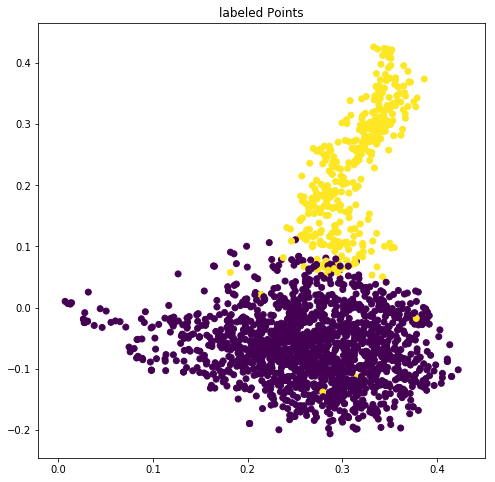

In [159]:
mapping=[]
for t in y_real:
    if (t == 0):
        mapping.append(200)
    else:
        mapping.append(10)


plt.figure(figsize=(8, 8)) 
plt.scatter(Xd[:,0],Xd[:,1], c=mapping)
plt.title("labeled Points")
plt.show()

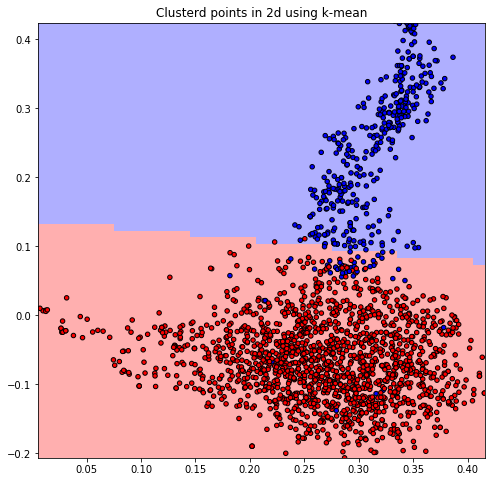

In [160]:


h = .01
# Plot the decision boundary. For that, we will assign a color to each

x_border = (Xd[:, 0].mean()/len(Xd))*10
y_border = (Xd[:, 1].mean()/len(Xd))*10

x_min, x_max = Xd[:, 0].min() - x_border, Xd[:, 0].max() + x_border
y_min, y_max = Xd[:, 1].min() - y_border, Xd[:, 1].max() + y_border
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

cmap_background = ListedColormap(['#FFAFAF', '#AFAFFF'])
cmap_points = ListedColormap(['#0000FF','#FF0000'])


# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)



plt.figure(figsize=(8, 8)) 
plt.pcolormesh(xx, yy, Z, cmap=cmap_background)

# Plot also the training points
plt.scatter(Xd[:, 0], Xd[:, 1], c=y_real, cmap=cmap_points,edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Clusterd points in 2d using k-mean")
plt.show()